# Create a synthetic data set, store, load, rechunk, store

In [1]:
import xarray as xr
import numpy as np

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.start_workers(4)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [9]:
client

Client Scheduler: tcp://10.148.1.6:52353 Dashboard: http://10.148.1.6:8787/status,Cluster Workers: 8 Cores: 32 Memory: 400.00 GB


---

## create a synthetic dataset

<xarray.Dataset>
Dimensions:  (t: 4112, x: 2056, y: 2056)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    v_t      (t) float64 dask.array<shape=(4112,), chunksize=(1,)>
    v_cx     (x) float64 dask.array<shape=(2056,), chunksize=(1028,)>
    v_cy     (y) float64 dask.array<shape=(2056,), chunksize=(1028,)>
    v        (t, x, y) float64 dask.array<shape=(4112, 2056, 2056), chunksize=(1, 1028, 1028)>

 data size: 139.1 GB


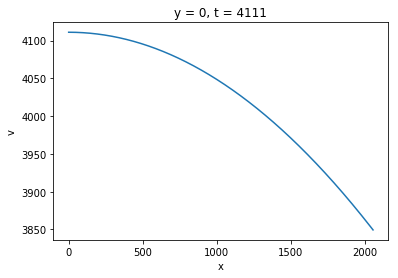

In [14]:
nx, ny, nt = 1028*2, 1028*2, 1028*4

ds = xr.Dataset({}, coords={'x':np.arange(nx),'y':np.arange(ny), 't': np.arange(nt)})

ds = ds.assign(v_t=ds.t*1.)
ds = ds.assign(v_cx=np.cos(np.pi/180./100*ds.x))
ds = ds.assign(v_cy=np.cos(np.pi/180./50*ds.y))

ds = ds.chunk({'t': 1, 'x': nx/2, 'y': ny/2})

ds = ds.assign(v=ds.v_t*ds.v_cx*ds.v_cy)

print(ds)

print('\n data size: %.1f GB' %(ds.v.nbytes / 1e9))

ds.v.isel(t=-1,y=0).plot()

In [ ]:
%time v = ds.v.load()

In [ ]:
%time v.std(dim='t').isel(x=0).plot()
# (selection after computation is intentional)

KeyboardInterrupt: 

---

## rechunk (in memory)

In [19]:
v = v.chunk({'t': len(v.t), 'x': 64, 'y': 64}).persist()

CPU times: user 724 ms, sys: 24 ms, total: 748 ms
Wall time: 1.66 s


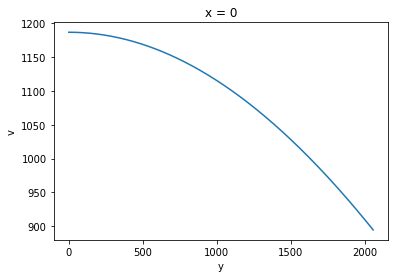

In [21]:
%time v.std(dim='t').isel(x=0).plot()
# (selection after computation is intentional)

In [ ]:
#from dask.dot import dot_graph
#dot_graph(ds['v'].dask)
#dict(ds['v'].data.dask)

---

In [15]:
cluster.scheduler.close()

<Future pending cb=[_make_coroutine_wrapper.<locals>.wrapper.<locals>.<lambda>() at /home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/gen.py:336]>